# Signal processing hackathon

Applying machine learning techniques to audio signals

In [151]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [152]:
# import numpy and matplotlib
%pylab inline
rcParams['figure.figsize'] = 20, 5

font = {'size': 16}
matplotlib.rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


In [153]:
# standard audio sample rate (samples per second)
sample_rate = 44100.

## Metadata

In [154]:
from metadata import *

In [5]:
# metadata about the people from which recordings are available
people

{'Andrew': {'age': 40,
  'gender': 'male',
  'mood': 'neutral',
  'nationality': 'Australian'},
 'Gabriele': {'age': 32,
  'gender': 'male',
  'mood': 'neutral',
  'nationality': 'Italian'},
 'Ivo': {'age': 35,
  'gender': 'male',
  'mood': 'neutral',
  'nationality': 'Dutch'},
 'Ivo2': {'age': 36,
  'gender': 'male',
  'mood': 'angry',
  'nationality': 'Dutch'},
 'Jelte': {'age': 24,
  'gender': 'male',
  'mood': 'neutral',
  'nationality': 'Dutch'},
 'Kaustav': {'age': 30,
  'gender': 'male',
  'mood': 'neutral',
  'nationality': 'Indian'},
 'Leo': {'age': 59,
  'gender': 'male',
  'mood': 'neutral',
  'nationality': 'Dutch'},
 'Marcel': {'age': 33,
  'gender': 'male',
  'mood': 'neutral',
  'nationality': 'Dutch'},
 'Nelli': {'age': 35,
  'gender': 'female',
  'mood': 'neutral',
  'nationality': 'Russian'},
 'Ron': {'age': 32,
  'gender': 'male',
  'mood': 'neutral',
  'nationality': 'Dutch'},
 'Stephen': {'age': 34,
  'gender': 'male',
  'mood': 'neutral',
  'nationality': 'English

In [156]:
# the sentences that have been recorded
sentences

{'s1': 'I want to implement a speech recognition system',
 's2': 'the fourier transform is super cool but rather complex'}

## Read data

In [157]:
# point to folder where data is stored
data_folder = 'speech_samples/'

In [158]:
# convert all m4a files in folder to wav with ffmpeg
import os
def m4a2wav(data_folder):
    m4a_list = [os.path.join(data_folder, file_name)
                for file_name in os.listdir(data_folder)
                if file_name.endswith('m4a')]
    for m4a_file in m4a_list:
        print(m4a_file)
        os.system('ffmpeg -y -i {} {}'.format(m4a_file, m4a_file[:-3]+'wav'))

# convert all m4a files
for person in people.keys():
    m4a2wav(os.path.join(data_folder, person))

In [172]:
# play a wav file
from IPython.display import *
def play_sound(data):
    global sample_rate
    if type(data) == str:
        return Audio(filename=data, autoplay=True, rate=sample_rate)
    else:
        return Audio(data.astype(int16), autoplay=True, rate=sample_rate)
    
play_sound(os.path.join(data_folder, 'Andrew', 's2.wav'))

In [160]:
# play a wave
play_sound((random.rand(100000)*500-500).astype(int16))

### Build a synthesizer - because we can

In [161]:
# so we can create electronic music!
def sinusoid(t, a, f, o=0):
    return a*sin(f*2*pi*t+o)

def create_sound(num_harmonics, bpm=80, duration=5, noise_easing=True):
    global sample_rate
    wave = zeros(duration*sample_rate)
    t = arange(len(wave))
    # add harmonics
    for i in range(num_harmonics):
        amp = 300 + random.rand() * 300
        frq = .01 + random.rand() * .01
        off = random.rand() * 5
        har = sinusoid(t, amp, frq, off)
        # add noise
        if noise_easing:
            har += 100 * t * random.rand(len(wave)) / max(t)
        wave += har
    # add beat
    beat_duration = int(sample_rate / (2 + random.rand() * 6))
    beat_amp = 2000 + random.rand() * 300
    beat_frq = .00001 + random.rand() * .0001
    beat_pos = int(sample_rate / (bpm / 60.))
    for bp in arange(beat_pos/2, len(wave), beat_pos):
        idx = arange(bp-beat_duration/2, bp+beat_duration/2).astype(int)
        wave[idx] += sinusoid(arange(len(idx)), beat_amp, beat_frq)
    return wave.astype(int16)

In [167]:
play_sound(create_sound(3, bpm=120, duration=3, noise_easing=True))

## Load the speech data

In [168]:
# read a wav file
import os
from scipy.io import wavfile
def read_wave(filepath):
    # sample rate is 44100
    sample_rate, audio_channels = wavfile.read(filepath)
    # return mono signal - there is no difference between left and right
    # and normalize to have 1/-1 as most loud/quite
    return audio_channels[:,0] / float(np.max(np.abs(audio_channels[:,0])))
    
s1 = read_wave(os.path.join(data_folder, 'Nelli', 's1.wav'));
s2 = read_wave(os.path.join(data_folder, 'Gabriele', 's1.wav'));

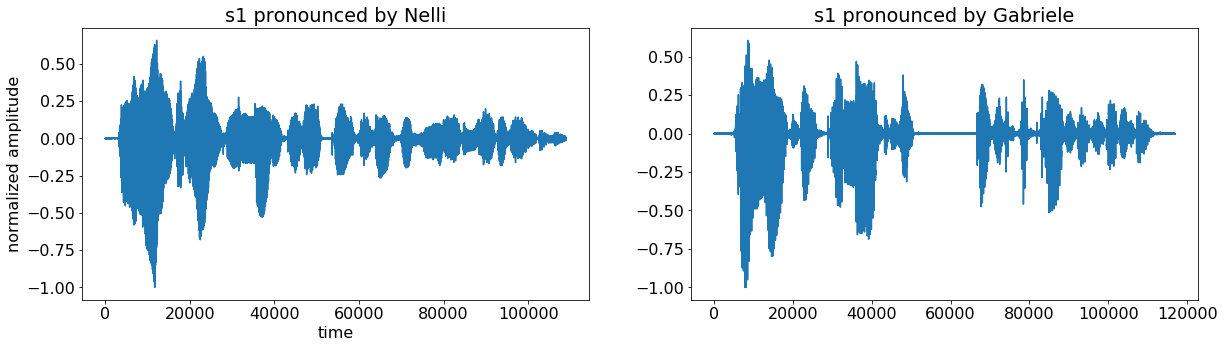

In [27]:
subplot(121); plot(s1); title('s1 pronounced by Nelli');
xlabel('time'); ylabel('normalized amplitude');
subplot(122); plot(s2); title('s1 pronounced by Gabriele');

Zoom in a bit; this is just a simple function/signal/timeseries/vector/array

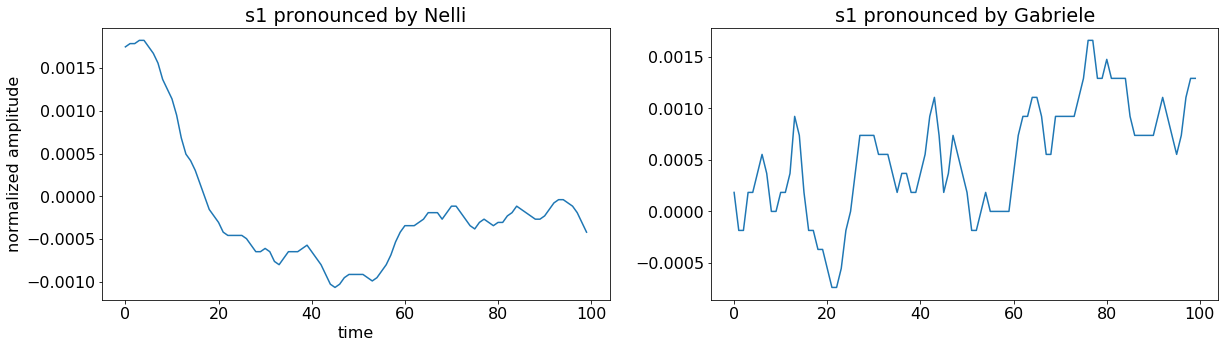

In [28]:
subplot(121); plot(s1[1000:1100]); title('s1 pronounced by Nelli');
xlabel('time'); ylabel('normalized amplitude');
subplot(122); plot(s2[1000:1100]); title('s1 pronounced by Gabriele');

## Extract features

In [173]:
# extract features from a wave with fft (which is just available due to the pylab namespace)
def fourier_transform(w):
    global sample_rate
    freq_bins = fft.rfftfreq(len(w), 1/sample_rate)
    power = absolute(fft.rfft(w))**2 / len(w)
    return power, freq_bins

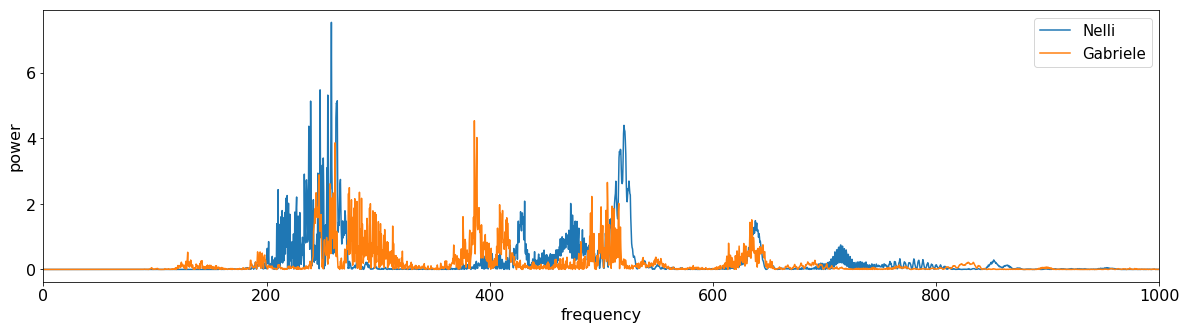

In [174]:
p1, f1 = fourier_transform(s1);
p2, f2 = fourier_transform(s2);
plot(f1, p1, label='Nelli');
plot(f2, p2, label='Gabriele');
pyplot.xlim([0, 1000]); pyplot.legend(fontsize=15);
xlabel('frequency'); ylabel('power');

Looks like we can extract discriminative features by summing the areas of chunks under these curves.

In [175]:
# feature extraction v1:
# extract the amount of power in a given frequency range
def power_at(power, freq, lbound, hbound):
    lbin = argmin(abs(freq - lbound))
    hbin = argmin(abs(freq - hbound))
    # TODO: correct for exact localization of the l and h frequencies
    return sum(power[lbin:hbin])

# feature extraction v2:
# use the integral representation instead => should be faster
def power_integral_at(pow_int, freq, lbound, hbound):
    lbin = argmin(abs(freq - lbound))
    hbin = argmin(abs(freq - hbound))
    return pow_int[hbin]-pow_int[lbin]

integral = lambda p, f, lb, hb: power_integral_at(p, f, lb, hb)
regular = lambda p, f, lb, hb: power_at(p, f, lb, hb)

# show the similarity! (and slight difference)
p1_int = cumsum(p1)
p2_int = cumsum(p2)
print('regular sum:\t', round(regular(p1, f1, 200, 300),1), round(regular(p2, f2, 200, 300),1))
print('cumulative sum:\t', round(integral(p1_int, f1, 200, 300),1), round(integral(p2_int, f2, 200, 300),1))

regular sum:	 234.3 143.1
cumulative sum:	 234.2 143.4


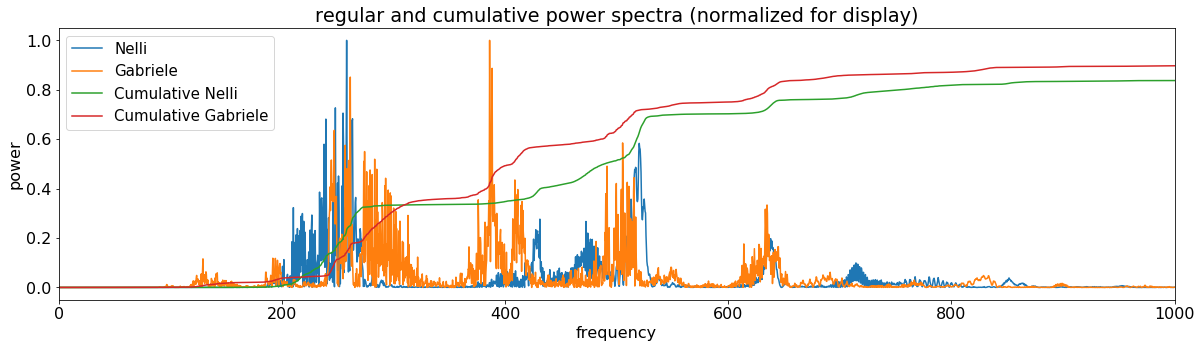

In [177]:
plot(f1, p1/max(p1), label='Nelli');
plot(f2, p2/max(p2), label='Gabriele');
plot(f1, p1_int/max(p1_int), label='Cumulative Nelli');
plot(f2, p2_int/max(p2_int), label='Cumulative Gabriele');
pyplot.xlim([0, 1000]); pyplot.legend(fontsize=15);
xlabel('frequency'); ylabel('power');
title('regular and cumulative power spectra (normalized for display)');

In [178]:
%timeit regular(p1, f1, 200, 50000)

1000 loops, best of 3: 225 µs per loop


In [179]:
%timeit integral(p1_int, f1, 200, 50000)

The slowest run took 4.60 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 193 µs per loop


## Create dataset

In [183]:
# dataset params
freq_step = 100
freq_max = 1000
lbounds = arange(0, freq_max, freq_step)
lbounds

array([  0, 100, 200, 300, 400, 500, 600, 700, 800, 900])

In [184]:
# compute features and labels
features = []
labels = []
# keep waves in memory for later usage
waves = []
for person in people.keys():
    for s in sentences.keys():
        w = read_wave(os.path.join(data_folder, person, '{}.wav'.format(s)));
        p, f = fourier_transform(w)
        p_int = cumsum(p)
        features.append(array([power_integral_at(p_int, f, b, b+freq_step) 
                               for b in lbounds]))
        labels.append([person,
                       people[person]['nationality'],
                       people[person]['gender'],
                       people[person]['mood'],
                       people[person]['age'],
                       s])
        waves.append(w)

In [182]:
# create dataframe
feature_columns = ['f{}'.format(i) for i in range(len(features[0]))]
label_columns = ['name', 'nationality', 'gender', 'mood', 'age', 'sentence']
dataset = pd.DataFrame(data=concatenate((features, labels), axis=1),
                       columns=concatenate((feature_columns, label_columns)))

# normalize the features
from sklearn import preprocessing
dataset[feature_columns] = preprocessing.StandardScaler() \
                           .fit_transform(dataset[feature_columns])

# also include numeric labels
for label in label_columns:
    dataset['n_{}'.format(label)] = preprocessing.LabelEncoder() \
                                    .fit_transform(dataset[label])
    
dataset.head(10).T

,0,1,2,3,4,5,6,7,8,9
f0,-0.452892,-0.428266,-0.318021,-0.307315,-0.455798,-0.24631,-0.278872,0.587272,0.149457,0.0238857
f1,0.895451,1.0307,-0.254476,-0.506275,0.75712,2.67089,-0.867343,1.13822,-0.223823,-0.203053
f2,-0.782518,-0.372298,0.328231,0.22104,-0.516405,-0.442438,-0.4743,-0.399315,-0.209019,-0.285676
f3,2.11693,-0.52921,1.09869,-0.586754,1.0186,-0.527223,-0.262874,0.237983,1.22632,-0.371251
f4,2.77606,0.330075,0.149303,-0.321393,-0.692431,-0.709907,0.0249795,-0.763873,0.796308,-0.495526
f5,3.79391,0.38986,0.99239,-0.396337,0.0952949,0.270848,-0.479184,-0.622555,-0.260205,-0.244593
f6,0.909965,-0.11977,1.25843,-1.2127,1.64921,0.267627,-1.05928,-0.480215,0.0530125,-0.825361
f7,2.18053,2.14686,-0.62548,-0.908874,1.99149,-0.345591,-0.614544,-0.266698,-0.611379,-0.694485
f8,-0.383462,-0.979487,2.47076,-0.510894,1.42974,-0.000427695,-0.36128,-0.817473,-0.513245,-0.583463
f9,-0.0371169,0.473293,3.05797,-0.581486,0.566298,-0.223584,-0.635978,-0.566513,-0.368214,-0.141276


In [185]:
# lazy coloring scheme ;)
from sklearn import cluster
colors = cluster.k_means(random.rand(100000,3), len(people))[0]

In [186]:
# wrapper for plotting, using global vars
from sklearn import discriminant_analysis, decomposition

def lda_plot(features=None):
    global dataset, label_columns, feature_columns, colors
    
    if features is None:
        features = dataset[feature_columns]
    
    lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)
    rcParams['figure.figsize'] = 20, 8

    for i, label in enumerate(label_columns):
        num_label = 'n_{}'.format(label)
        lda_feats = lda.fit_transform(features,
                                      dataset[num_label])
        subplot(3, 2, i+1)
        if lda_feats.shape[1] == 2:
            x = lda_feats[:,0]
            y = lda_feats[:,1]
        else:
            x = arange(len(lda_feats))
            y = lda_feats

        for j, l in enumerate(unique(dataset[num_label])):
            idx = (dataset[num_label]==l).values
            scatter(x[idx], y[idx], c=colors[j], s=80);

        title(label);
        legend(unique(dataset[label]), loc=5);
        tight_layout()

    rcParams['figure.figsize'] = 20, 5

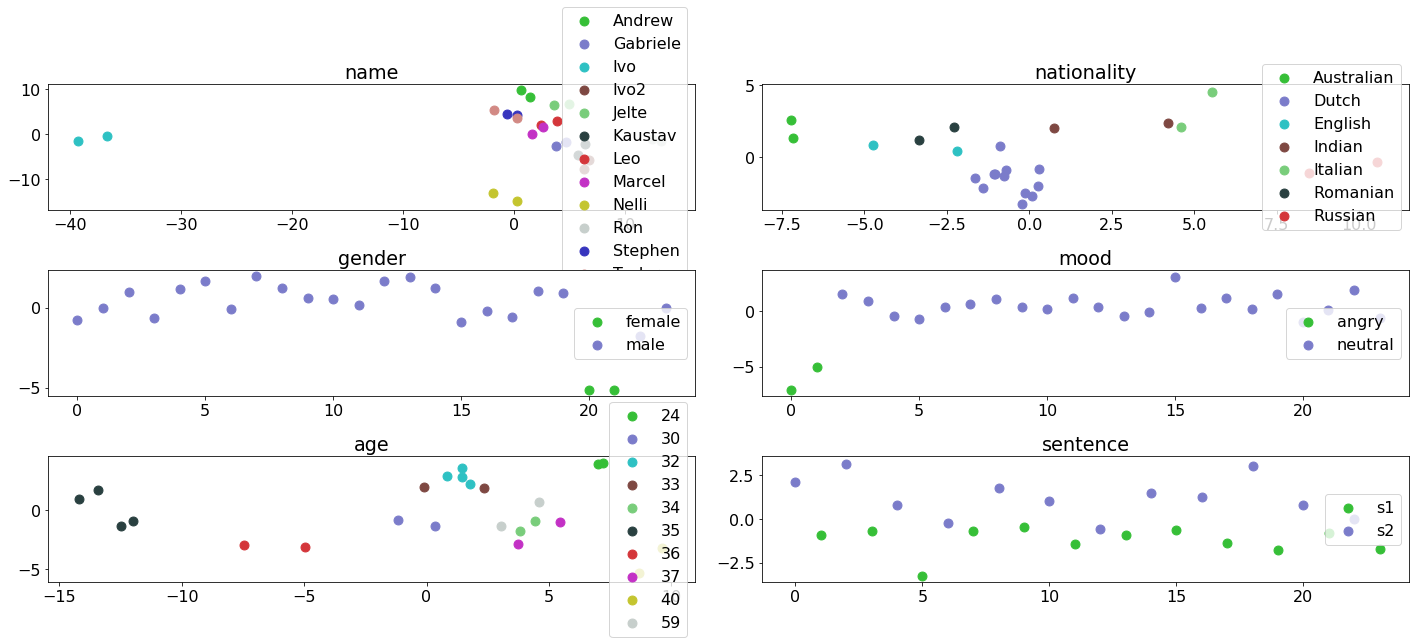

In [187]:
lda_plot()

Distribution of FFT features

## Word tokenization

In [188]:
# how many words in each sentence
len(sentences['s1'].split()), len(sentences['s2'].split())

(8, 9)

In [189]:
# could it be that by convolving with a gaussian derivative filter the zero crossings mark the words...?
from scipy import ndimage

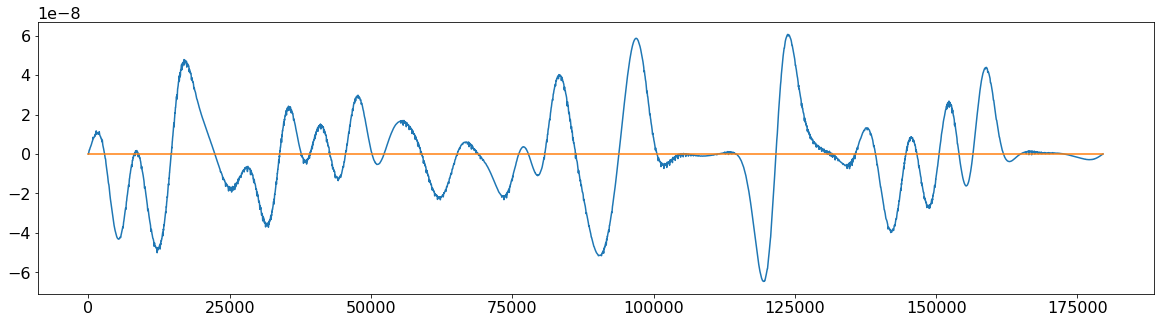

In [190]:
w = waves[10]
dw = ndimage.gaussian_filter1d(w, sample_rate/20, order=1);
plot(dw); plot([0, len(dw)], [0, 0]);

In [191]:
# find close-to-zero derivatives and see if they provide usefull segments
idx = abs(dw)<1e-12
where(idx)[0]

array([ 52302,  76145, 105147, 105183, 105400, 105415, 105563, 105576,
       111299, 111343, 111344, 111345, 111440, 111441, 112714, 114605,
       114606, 114607, 114617, 114618, 130868, 131543, 164932, 172653,
       172654, 179510])

In [192]:
# hm
play_sound(w[114618:130868]*500)

Nevermind the word tokenization ;)

## Bag-of-Words

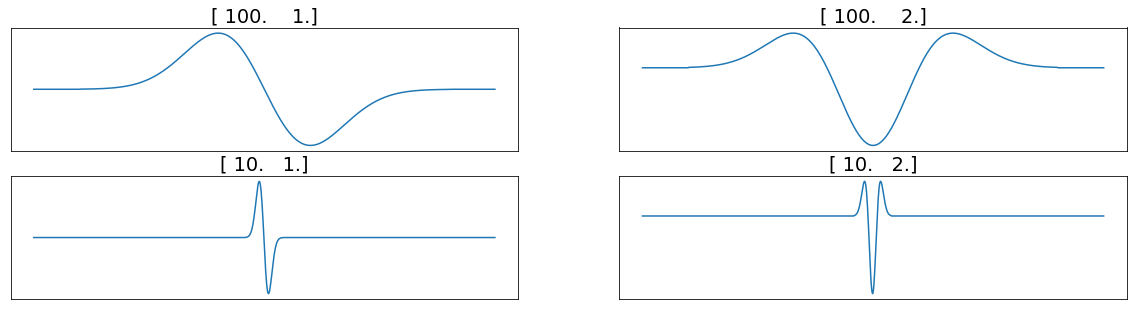

In [110]:
# use a filterbank of gaussian derivatives ('njet') for feature extraction
import scipy.ndimage as ndi
def apply_filter_bank(signal):
    # use 2 different filter sizes
    stds = array([1e-1, 1e-2]) * 1000
    # use 2 differential orders
    orders = [1,2]
    # store result
    f = []
    params = []
    for s in stds:
        for o in orders:
            f.append(ndi.gaussian_filter(signal, s, o))
            params.append([s,o])
    return array(f), array(params)

# show the filters by convolving with a spike
spike = zeros(1001); spike[500] = 1;
f_spikes, params = apply_filter_bank(spike)
for i, f_spike in enumerate(f_spikes):
    subplot(2, 2, i+1);
    extend = 150*int(params[i,0])
    plot(f_spike[len(f_spike)/2-extend:len(f_spike)/2+extend]);
    xticks([]); yticks([]);
    title(params[i,:])

Gaussian filters with different scales and differential orders

In [111]:
# extract 'local features':
# apply the filter bank and summarize the filter output with aggs over regions of size fsize in steps of size step
def extract_local_features(signal,
                           fsize=int(sample_rate/8), step=int(sample_rate/32), aggs=[max],
                           standardize=True):
    f_signal = apply_filter_bank(signal)[0]
    samples = arange(0, len(signal)-fsize/2, step).astype('int')
    feats = zeros((len(samples), f_signal.shape[0]*len(aggs)))
    n_row = 0
    for i in samples:
        n_col = 0
        for agg in aggs:
            for f in f_signal[:, i:i+fsize]:
                feats[n_row, n_col] = agg(f)
                n_col += 1
        n_row += 1
    return preprocessing.StandardScaler().fit_transform(feats) if standardize else feats

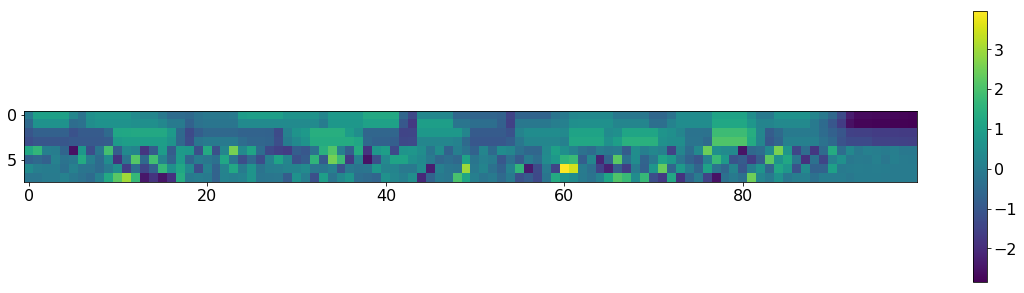

In [194]:
# look at 1 example
feats = extract_local_features(waves[0], aggs=[max, mean], standardize=True)
imshow(feats.T)
colorbar();

We have chopped up the signal in about 100 pieces, and extracted 8 numbers from every piece.

In [124]:
# extract all local features
def extract_local_features_wrapper(i):
    global waves
    return extract_local_features(waves[i], standardize=False)

# feature extraction is heavy - hooray to multiprocessing
from multiprocessing import Pool
thread_pool = Pool(6)
all_local_feats = thread_pool.map(extract_local_features_wrapper, range(len(waves)));

In [125]:
# create vocabulary
k = 10
n_feats_per_sample = 50
feats_for_clustering = zeros((n_feats_per_sample*len(waves),
                              all_local_feats[0].shape[1]))

# harvest features for clustering
for i, local_feats in enumerate(all_local_feats):
    feats_for_clustering[i*n_feats_per_sample:(i+1)*n_feats_per_sample,:] = \
                         random.permutation(local_feats)[:n_feats_per_sample]

# train standard scaler
bow_scaler = preprocessing.StandardScaler().fit(feats_for_clustering)
        
# kmeans object for clustering
vocab = cluster.KMeans(n_clusters=k)
vocab.fit(bow_scaler.transform(feats_for_clustering))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [126]:
# use the vocab for quantizing the local features into a fixed-length representation
bow_feats = zeros((len(waves), k))
for i, local_feats in enumerate(all_local_feats):
    bow_hist, _ = histogram(vocab.predict(bow_scaler.transform(local_feats)), k)
    bow_feats[i,:] = preprocessing.normalize(bow_hist.reshape(1,-1))
bow_feats.shape

(24, 10)

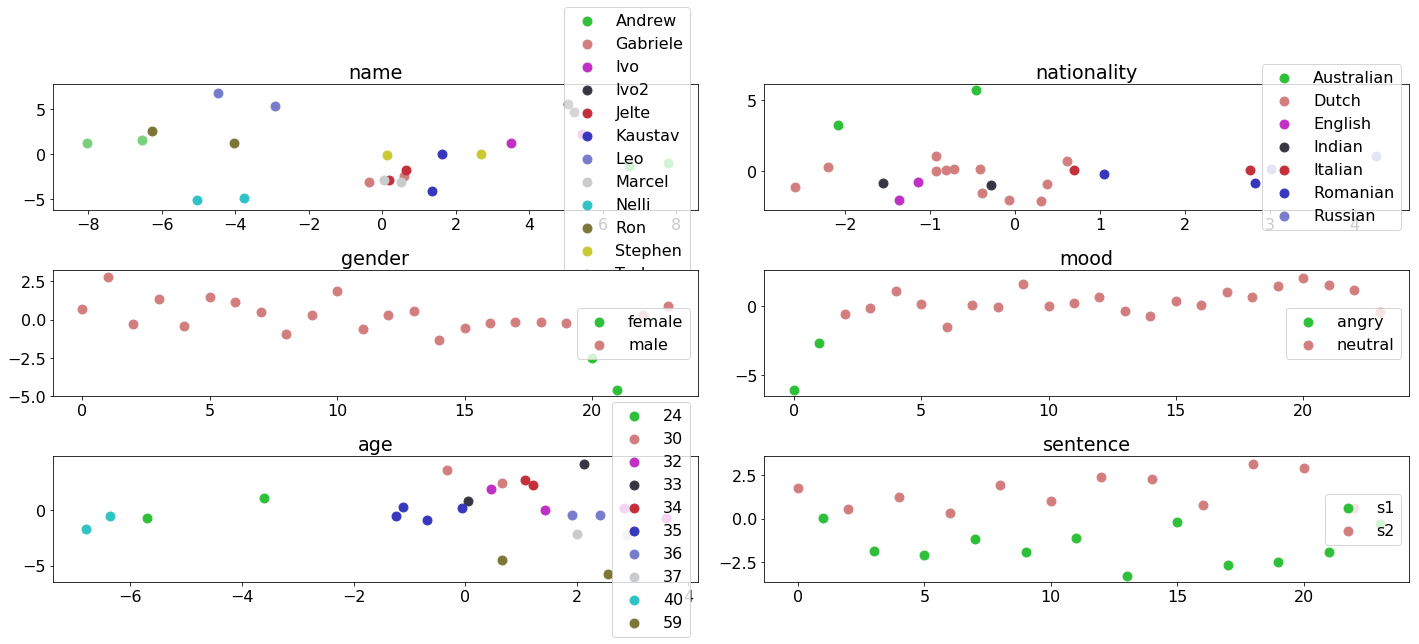

In [127]:
# show 'm
lda_plot(bow_feats)

Distribution of BoW features

## Let's do a round of classification

In [128]:
# using leave-1-out model validation with your favorite classifier and normalizer
from sklearn import neighbors, cross_validation
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

def l1o_val(data, labels,
            classifier = neighbors.KNeighborsClassifier(1),
            normalizer = preprocessing.StandardScaler()):
    
    if isinstance(data, pd.DataFrame):
        data = data.values.astype('float')
    
    l1o = cross_validation.LeaveOneOut(data.shape[0])
    predictions = np.zeros(labels.shape, dtype=labels.dtype)
    
    for train_idx, test_idx in l1o:
        if isinstance(normalizer, discriminant_analysis.LinearDiscriminantAnalysis):
            train_data = normalizer.fit_transform(data[train_idx], labels[train_idx])
        else:
            train_data = normalizer.fit_transform(data[train_idx])
        classifier.fit(train_data, labels[train_idx])
        predictions[test_idx] = classifier.predict(normalizer.transform(data[test_idx]))
    
    return sum(predictions == labels) / float(data.shape[0])

Experiment with raw features / pca / lda

In [129]:
# custom function for plotting classification results
# exp_res should have a 'label', 'method' and 'result' column
def grouped_bar_plot(exp_res):
    exp_res.pivot('label', 'method', 'result').plot(kind='bar')
    legend(loc='best')

def exp_res_df(*data):
    if data[0] is not None:
        data = [[d for d in data]]
    else:
        data = None
    return pd.DataFrame(data=data, columns=['label', 'method', 'result'])

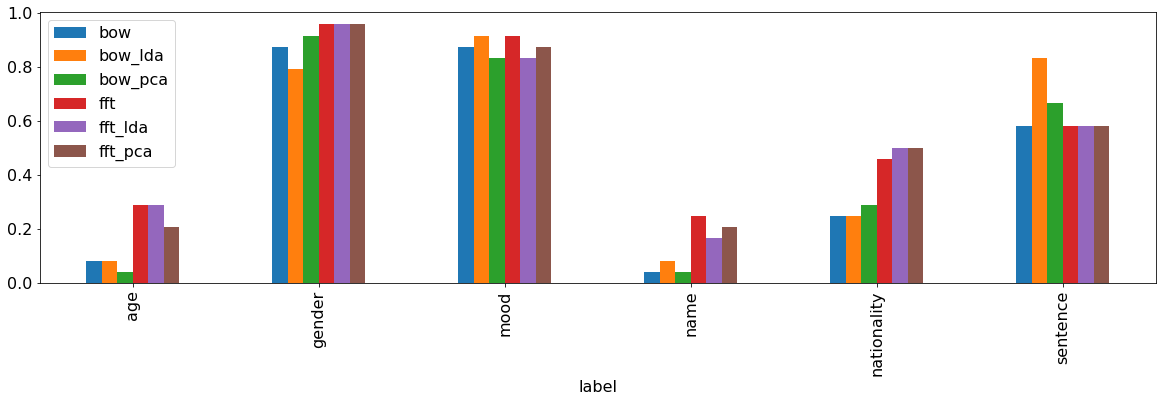

In [130]:
pca = decomposition.PCA(n_components=6)
lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=3)
df = exp_res_df(None)
for label in label_columns:
    labels = dataset['n_{}'.format(label)]
    df = pd.concat((df, exp_res_df(label, 'fft', l1o_val(dataset[feature_columns], labels)),
                        exp_res_df(label, 'bow', l1o_val(bow_feats, labels)),
                        exp_res_df(label, 'fft_pca', l1o_val(dataset[feature_columns], labels, normalizer=pca)),
                        exp_res_df(label, 'bow_pca', l1o_val(bow_feats, labels, normalizer=pca)),
                        exp_res_df(label, 'fft_lda', l1o_val(dataset[feature_columns], labels, normalizer=lda)),
                        exp_res_df(label, 'bow_lda', l1o_val(bow_feats, labels, normalizer=lda))))
grouped_bar_plot(df)

Lot of info is destroyed by chopping up the signal and throwing the features in an orderless bag-of-words, but lda might save the day. Main message: try out several combinations and parameters and pick the best one for your problem.

Note that LDA suffers greatly from leaving-one-out.

### Extract features with convolution while preserving feature order (i.e. discard BoW)

In [131]:
def extract_sequential_local_features_wrapper(i):
    global waves
    w = waves[i]
    return extract_local_features(w, fsize=int(len(w)/10), step=int(len(w)/10), standardize=False).flatten()

# feature extraction is heavy - hooray to multiprocessing
thread_pool = Pool(6)
local_seq_feats = thread_pool.map(extract_sequential_local_features_wrapper, range(len(waves)));

In [132]:
seq_feats = preprocessing.StandardScaler().fit_transform(array(local_seq_feats))
seq_feats.shape

(24, 40)

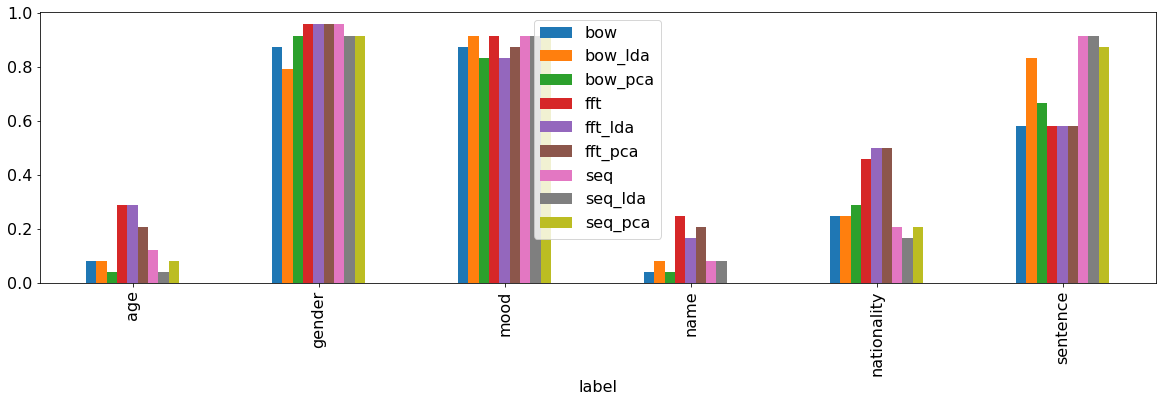

In [133]:
# compare fft with bow and conv features
seq_pca = decomposition.PCA(n_components=6)
seq_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=6)
df = exp_res_df(None)
for label in label_columns:
    labels = dataset['n_{}'.format(label)]
    df = pd.concat((df, exp_res_df(label, 'fft', l1o_val(dataset[feature_columns], labels)),
                        exp_res_df(label, 'bow', l1o_val(bow_feats, labels)),
                        exp_res_df(label, 'seq', l1o_val(seq_feats, labels)),
                        exp_res_df(label, 'fft_pca', l1o_val(dataset[feature_columns], labels, normalizer=pca)),
                        exp_res_df(label, 'bow_pca', l1o_val(bow_feats, labels, normalizer=pca)),
                        exp_res_df(label, 'seq_pca', l1o_val(seq_feats, labels, normalizer=seq_pca)),
                        exp_res_df(label, 'fft_lda', l1o_val(dataset[feature_columns], labels, normalizer=lda)),
                        exp_res_df(label, 'bow_lda', l1o_val(bow_feats, labels, normalizer=lda)),
                        exp_res_df(label, 'seq_lda', l1o_val(seq_feats, labels, normalizer=seq_lda))))
grouped_bar_plot(df)

Sometimes better than BoW indeed. The feature type depends on the problem!

## Convolutional neural networks

In [196]:
# lets try to do similar stuff with a convnet
from keras.layers.convolutional import Convolution1D
from keras.models import Sequential
from keras.layers import Input, Activation, Flatten, Dense, Dropout

In [197]:
# use fixed length waves
max_duration = max([len(w) for w in waves])
pwaves = array([concatenate((w, zeros((max_duration-len(w),)))) for w in waves])
pwaves = pwaves.reshape(pwaves.shape + (1,))
pwaves.shape

(24, 181248, 1)

In [198]:
# convert labels (sentence1/sentence2) to something keras understands
from keras.utils.np_utils import to_categorical
keras_labels = to_categorical(dataset['n_sentence'].astype('int'), 2)

In [203]:
# build the model for classifying into 2 classes (sentence 1 and sentence 2)
num_filters = 2
filter_size = 5
model = Sequential()
model.add(Convolution1D(num_filters, filter_size, input_dim=1, input_length=max_duration))
model.add(Flatten())
model.add(Dense(2)) # s1/s2
model.add(Activation('softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [204]:
# fit the model using train- and validation- data
model.fit(pwaves[:-4], keras_labels[:-4],
          batch_size=4,
          nb_epoch=5,
          validation_data=(pwaves[-4:], keras_labels[-4:]));

Train on 20 samples, validate on 4 samples
Epoch 1/5
20/20 [==============================] - 0s - loss: 0.7375 - acc: 0.4500 - val_loss: 1.3686 - val_acc: 0.0000e+00
Epoch 2/5
20/20 [==============================] - 0s - loss: 1.4097e-04 - acc: 1.0000 - val_loss: 1.7623 - val_acc: 0.2500
Epoch 3/5
20/20 [==============================] - 0s - loss: 1.9432e-05 - acc: 1.0000 - val_loss: 2.0562 - val_acc: 0.2500

In [205]:
# see if the model can classify the test data
res = model.evaluate(pwaves[-4:], keras_labels[-4:], verbose=0)
for i, m in enumerate(model.metrics_names):
    print(m, res[i])

loss 2.37046837807
acc 0.25


#### Visualize the convolution filters

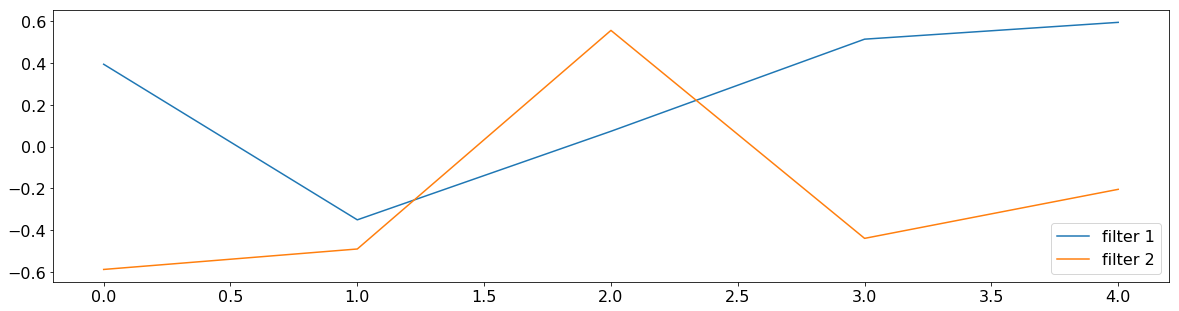

In [206]:
filters = model.layers[0].get_weights()
for i, f in enumerate(filters[0].reshape(filter_size, num_filters).T):
    plot(f, label='filter {}'.format(i+1))
legend();